<a href="https://colab.research.google.com/github/CharlotteHoyt/KWK-Goldman-Sachs-ML-Titanic-Survival-Data-Decision-Trees-Random-Forests-and-K-Nearest-Neighbors/blob/main/Charlotte_Hoyt_Titanic_Survival_Data_Decision_Trees%2C_Random_Forests%2C_and_K_Nearest_Neighbors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#KWK Machine Learning Challenge 2025
##Titanic Survival Data - Decision Trees, Random Forests, and K-Nearest Neighbors

This Notebook contains practice exercises for the Machine Learning Challenge guided curriculum lessons below:


*   ML2.1 - Decision Trees
*   ML2.2 - Random Forests
*   ML3.1 - K-Nearest Neighbords

TODO comments are added where you should fill in your own code.

## Loading and Cleaning Data

Similarly to the previous notebook, we need to load and clean our dataset. This portion is done for you, since it is a repeat of concepts you've already learned. You will, however, need to replace the path to a file on your own Google Drive.

In [68]:
# For more information on this, see this link: https://colab.research.google.com/notebooks/io.ipynb
from google.colab import drive
drive.mount('/content/drive')

# Basic import statements
import pandas as pd
from scipy import stats

#Replace the path below with the path to the file on your own Google Drive.
df = pd.read_csv("/content/drive/My Drive/KWK_ML/titanic.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Cleaning Data
We need to do the following:

*   Fill missing `Age` values with the median age.
*   Fill missing `Embarked` values with the most common port (mode).
*   Drop the `Cabin` column since most values are missing.

In [69]:
# Fill missing Age values with the median age
median_age = df['Age'].median()
df['Age'] = df['Age'].fillna(median_age)

# Fill missing Embarked values with the most common port (mode)
most_common_port = df['Embarked'].mode()[0]
df['Embarked'] = df['Embarked'].fillna(most_common_port)

# Drop the Cabin column since most values are missing
df.drop(columns=['Cabin'], inplace=True)

# re-run df.info() and see that the columns have updated as we expect.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


Let's also add the `FamilySize` feature from the previous notebook.

In [70]:
# Add the columns `Parch` and `SibSp` and assign them to a
# new column called `FamilySize`
df['FamilySize'] = df['Parch'] + df['SibSp']

# ML2.1.1 - Decision Trees

In this section, we will create a decision tree. Before we do that, we need to engineer a new feature. The current `Sex` column stores passengers' sex as string values. Our decision tree model needs to take this column in as a numeric value. So, let's engineer a new feature, `Sex_Female`, where the value is `1` if the passenger is female and `0` if they are male.

In [71]:
# Feature engineering: Create a new column, Sex_Female, using the Sex column with 0 = male, 1 = female

# Step one: print all unique values in the Sex column. This allows us to see whether
# we need to do any string manipulation before we map the values
print(set(df["Sex"].values))

{'female', 'male'}


In [72]:
# Step two: create a new column with mapped values:
# 0 for male, 1 for female

# TODO: create the above-described column, named `Sex_Female`
df['Sex_Female'] = df ['Sex'].map({'male': 0, 'female': 1})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
 11  FamilySize   891 non-null    int64  
 12  Sex_Female   891 non-null    int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 90.6+ KB


Next, let's also engineer another feature that one-hot encodes the `Embarked` column, since that column is similarly a text-based categorical variable.

In [73]:
# Step one: print all unique values in the Embarked column. This allows us to see whether
# we need to do any string manipulation before we map the values
print(set(df["Embarked"].values))

{'S', 'C', 'Q'}


In [74]:
# Step two: create the new columns using `get_dummies`

# TODO: Get one hot encoding of column 'Embarked' and add to the existing df
df = pd.get_dummies(df, columns = ['Embarked'], drop_first = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  FamilySize   891 non-null    int64  
 11  Sex_Female   891 non-null    int64  
 12  Embarked_Q   891 non-null    bool   
 13  Embarked_S   891 non-null    bool   
dtypes: bool(2), float64(2), int64(7), object(3)
memory usage: 85.4+ KB


## Training the Decision Tree Model
Now let's work on training the model, interpreting it, and evaluating it against testing data.

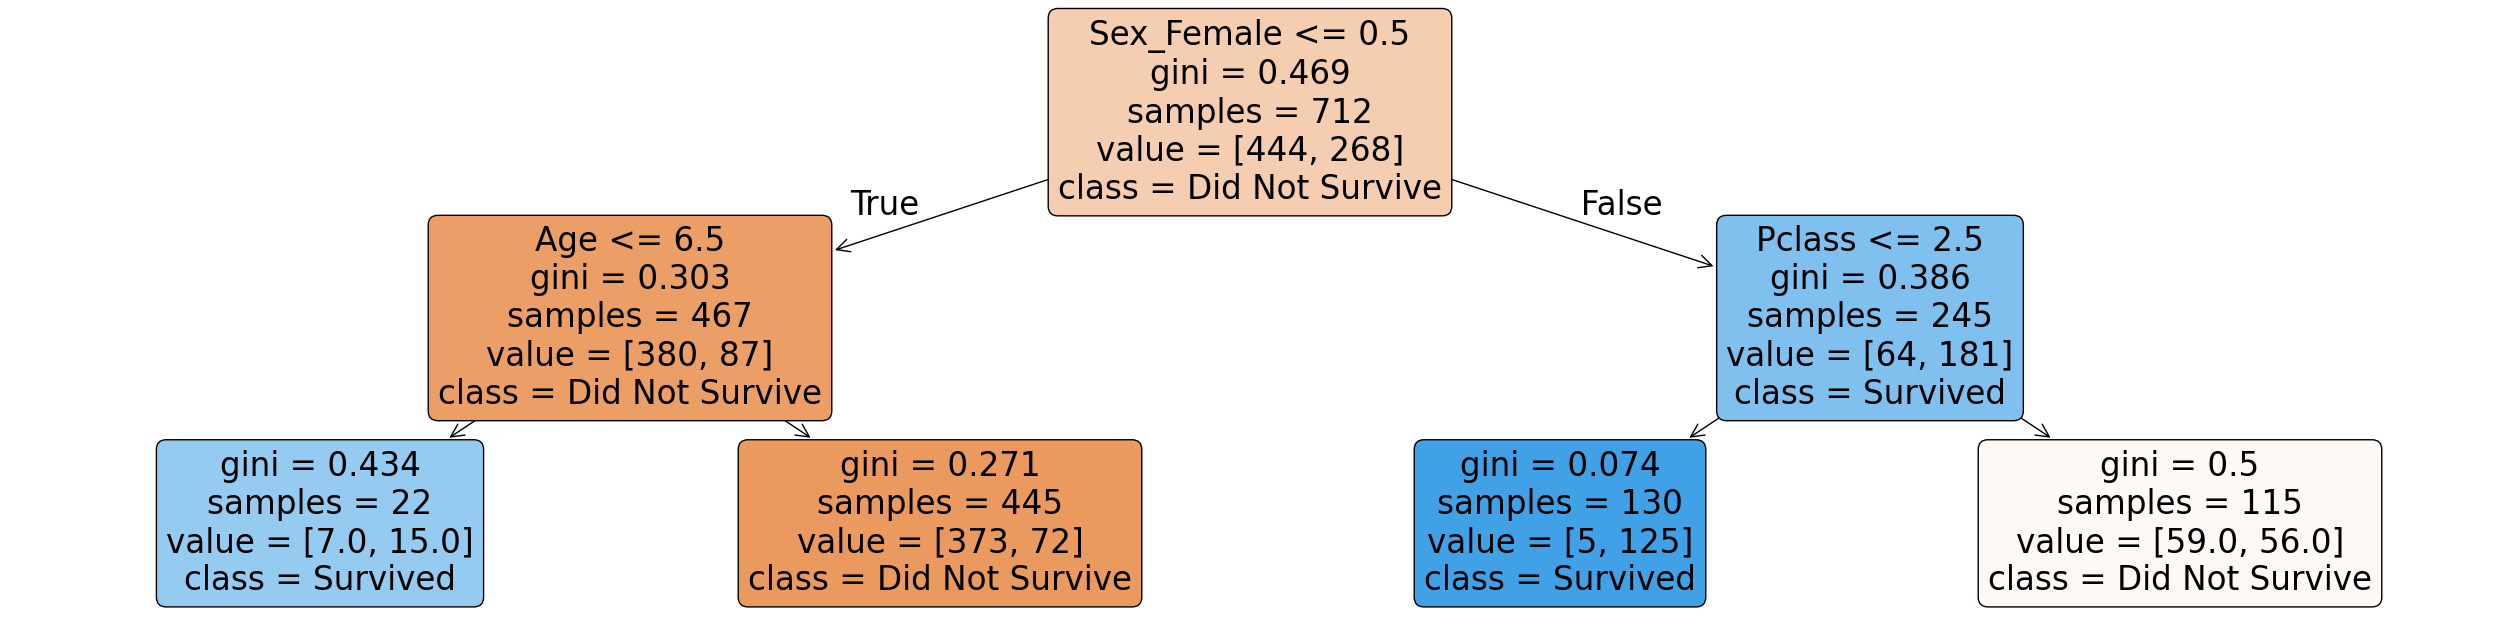


Feature Importance:
       Feature  Importance
4  Sex_Female    0.716449
0      Pclass    0.200746
1         Age    0.082805
2        Fare    0.000000
3  FamilySize    0.000000
5  Embarked_Q    0.000000
6  Embarked_S    0.000000



ACCURACY FOR THE TRAINING SET
Accuracy: 0.8033707865168539

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.97      0.86       444
           1       0.92      0.52      0.67       268

    accuracy                           0.80       712
   macro avg       0.85      0.75      0.76       712
weighted avg       0.83      0.80      0.79       712

ACCURACY FOR THE TEST SET
Accuracy: 0.7653631284916201

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.95      0.83       105
           1       0.88      0.50      0.64        74

    accuracy                           0.77       179
   macro avg       0.81      0.73      0.73       179
weig

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Step one: Gather the features we want to use in the model into X
X = df[["Pclass", "Age", "Fare", "FamilySize", "Sex_Female", "Embarked_Q", "Embarked_S"]]
y = df["Survived"]

# Step two: Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step three: Train the decision tree
## TODO: step 3 as described.
model = DecisionTreeClassifier(
    criterion = "gini",
    max_depth = 2,
    random_state = 42
)
model.fit(X_train, y_train)

# Step five: Visualize the tree
## TODO: step 5 as described.
plt.figure(figsize = (32, 8))
plot_tree(
    model,
    feature_names = X.columns,
    class_names = ["Did Not Survive", "Survived"],
    filled = True,
    rounded = True
)
plt.show()

# Step six: List Feature importance
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importance:\n", feature_importance)

print("\n\n")

# Step seven: Evaluate on the training set
print("ACCURACY FOR THE TRAINING SET")
y_pred_train = model.predict(X_train)
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))

# Step seven: Evaluate on the test set
print("ACCURACY FOR THE TEST SET")
y_pred_test = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))




## Evaluating the model
Accuracy on the model above is:
*    80.3% for the training set
*    76.5% for the test set.

This is pretty good! Let's see if we can push for better by tuning some of the parameters of the model, though. Specifically, we will:
*  Increase `max_depth` from 2 to 4
*  Set `min_samples_split` to 5
* Set `min_samples_leaf` to 3



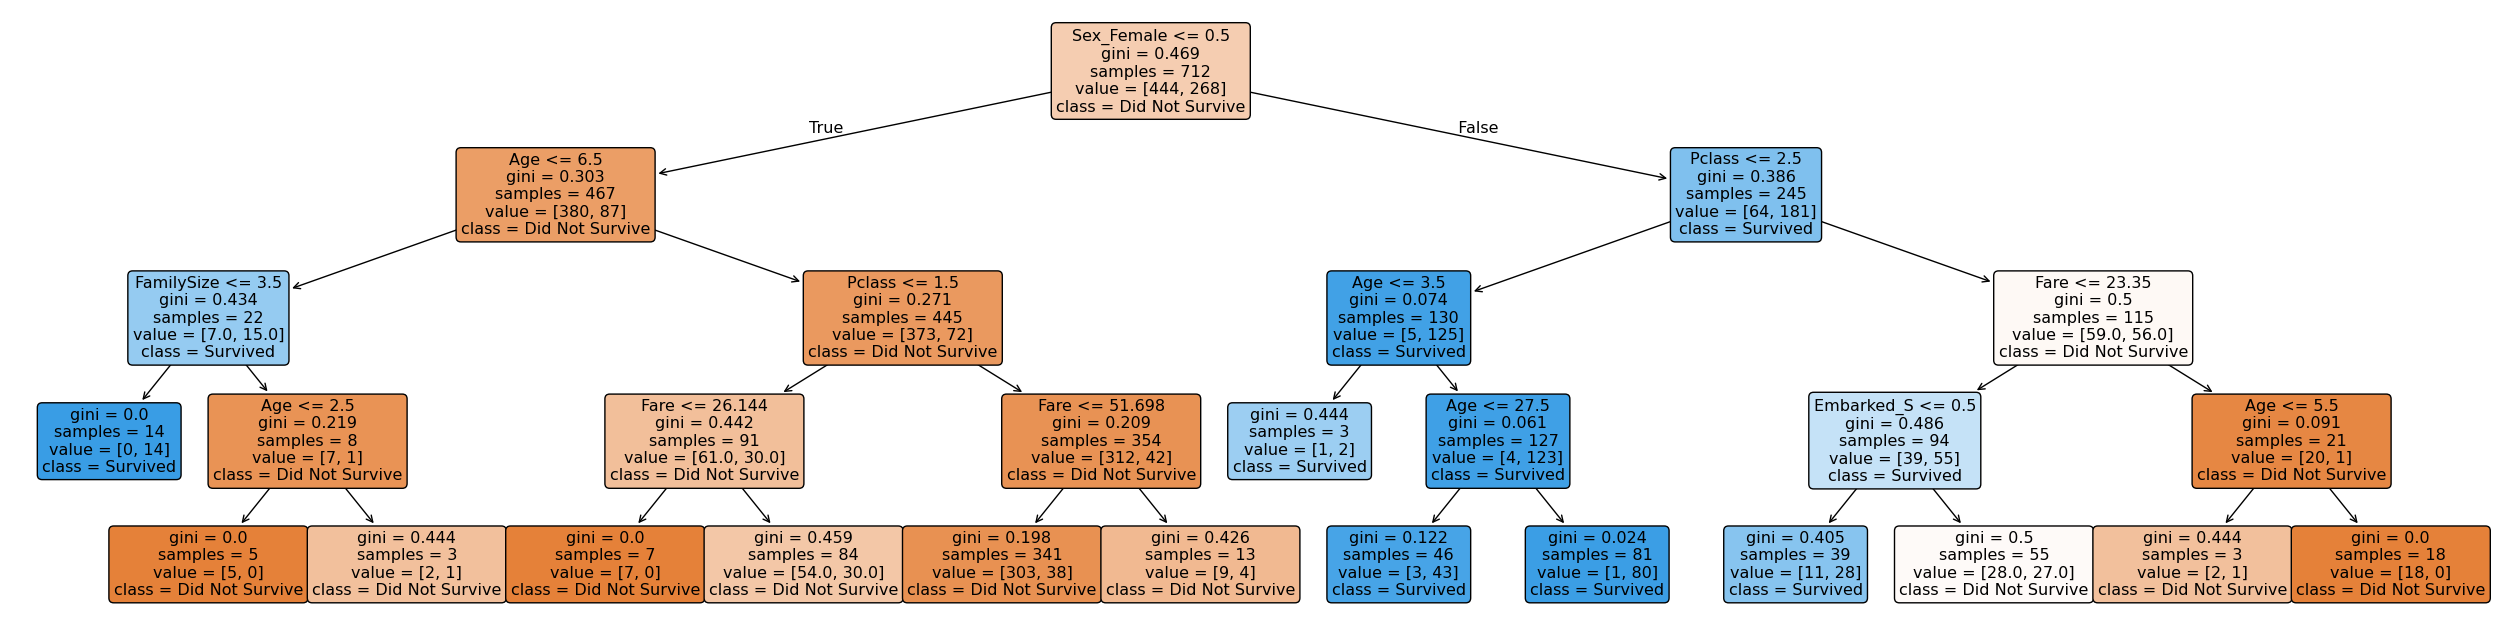


Feature Importance:
       Feature  Importance
4  Sex_Female    0.584841
0      Pclass    0.202308
1         Age    0.077646
2        Fare    0.074705
3  FamilySize    0.046474
6  Embarked_S    0.014025
5  Embarked_Q    0.000000



ACCURACY FOR THE TRAINING SET
Accuracy: 0.8356741573033708

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.96      0.88       444
           1       0.91      0.62      0.74       268

    accuracy                           0.84       712
   macro avg       0.86      0.79      0.81       712
weighted avg       0.85      0.84      0.83       712

ACCURACY FOR THE TEST SET
Accuracy: 0.7988826815642458

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.91      0.84       105
           1       0.84      0.64      0.72        74

    accuracy                           0.80       179
   macro avg       0.81      0.77      0.78       179
weig

In [76]:
# Steps 1 and 2 remain above; we'll use the same split of training and testing data.

# Step three: Train the decision tree (this is where we change parameters)
# TODO: step 3 as described.
model = DecisionTreeClassifier(
    criterion = "gini",
    max_depth = 4,
    min_samples_split= 5,
    min_samples_leaf = 3,
    random_state = 42
)
model.fit(X_train, y_train)

# Step five: Visualize the tree
plt.figure(figsize=(32, 8))
plot_tree(
    model,
    feature_names=X.columns,
    class_names=["Did Not Survive", "Survived"],
    filled=True,
    rounded=True
)
plt.show()

# Step six: List Ffature importance
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importance:\n", feature_importance)

print("\n\n")

# Step seven: Evaluate on the training set
print("ACCURACY FOR THE TRAINING SET")
y_pred_train = model.predict(X_train)
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))

# Step seven: Evaluate on the test set
print("ACCURACY FOR THE TEST SET")
y_pred_test = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))

This seems a bit better! Accuracy for the new model above is:
*    83.6% for the training set
*    79.9% for the test set.

This still represents an optimal balance between overfitting and not fitting strongly enough to the test data.


# ML.2.2.1 - Random Forests

Next, let's level up to random forests: ensembles of many decision trees with their results combined through voting for which category (survived, or not survived) to predict for a given passenger.


ACCURACY FOR THE TRAINING SET
Accuracy: 0.8637640449438202

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.90       444
           1       0.91      0.71      0.80       268

    accuracy                           0.86       712
   macro avg       0.88      0.83      0.85       712
weighted avg       0.87      0.86      0.86       712


ACCURACY FOR THE TEST SET
Accuracy: 0.8212290502793296

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.91      0.86       105
           1       0.85      0.69      0.76        74

    accuracy                           0.82       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



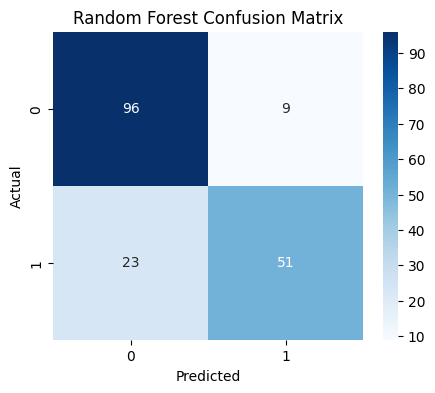


Feature Importance:
       Feature  Importance
4  Sex_Female    0.449947
2        Fare    0.170931
0      Pclass    0.143746
1         Age    0.121840
3  FamilySize    0.081702
6  Embarked_S    0.023800
5  Embarked_Q    0.008034


In [81]:
# Step 1. Import libraries ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Step 2. Select features
X = df[["Pclass", "Age", "Fare", "FamilySize", "Sex_Female", "Embarked_Q", "Embarked_S"]]
y = df["Survived"]

# Step 3. Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 4. Train a Random Forest model
# TODO: Step 4 as described
forest = RandomForestClassifier(
    n_estimators = 100, # Number of trees in the forest.
    max_depth = 5, # Limit tree depth to avoid overfitting.
    min_samples_split = 5, # Min samples to split an internal node.
    min_samples_leaf = 2, # Min samples allowed in a leaf.
    random_state = 42
)
forest.fit(X_train, y_train)

# Step 5: Evaluate on the training set
print("\nACCURACY FOR THE TRAINING SET")
y_pred_train = forest.predict(X_train)
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))

# Step 6: Evaluate on the test set
print("\nACCURACY FOR THE TEST SET")
y_pred_test = forest.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))

# Step 7. Visualize the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Step 8. Feature importance
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": forest.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importance:\n", importance_df)


## 💬 Reflection: Decision Tree vs. Random Forest

Now that you've trained both models, let's compare their results and think about what they tell us.

| Model             | Train Accuracy | Test Accuracy | Notes                                  |
| ----------------- | -------------- | ------------- | -------------------------------------- |
| **Decision Tree** | 0.84           | 0.80          | Pretty good!  |
| **Random Forest** | 0.86           | 0.82          | Slightly higher accuracy. |

### 1. Generalization

The Decision Tree learned slightly too specific patterns from the training data (0.84 → 0.80).

The Random Forest has a proportionally smaller gap (0.86 → 0.82), meaning it generalizes better to unseen data.

This is the core strength of ensemble learning: by combining many imperfect trees, the forest smooths out individual quirks and random noise.

### 2. Precision, Recall, and Trade-offs
| Metric                          | Decision Tree | Random Forest | Interpretation                                                           |
| ------------------------------- | ------------- | ------------- | ------------------------------------------------------------------------ |
| **Precision (Survived)**        | 0.84          | 0.85          | Both are good at correctly identifying survivors.                        |
| **Recall (Survived)**           | 0.64          | 0.69          | The Random Forest catches a few more true survivors.                     |
| **Precision (Did not survive)** | 0.78          | 0.81          | Both predict non-survivors accurately, but the forest slightly improves. |
| **Recall (Did not survive)**    | 0.91          | 0.91          | Essentially the same: both correctly identify most non-survivors.       |

Notice the small but consistent improvements across metrics.

### 3. Questions for Reflection

Type your answers below:

**Why did the Random Forest achieve higher recall for survivors?**

TODO: The random forest achieved higher recall for survivors because random forests use "collective wisdom," meaning a forest is more accurate and stable than a single tree.

**How does bootstrapping with replacement make the model more reliable?**

TODO: Bootstrapping with replacement makes the model more reliable because not every tree is given the same training data. (The same row can even be selected multiple times in a selection of samples!) This makes it so not every tree is seeing the same data. The data overlaps, but it reduces correlation between trees. Slightly shuffled trees allow us to "average" multiple different trees and make a better general view.

**What trade-off do we accept by using a Random Forest instead of one interpretable tree?**

TODO: Random forests are harder to visualize since they "don't give you one tidy tree to read." We have to rely on feature importance to understand which features were the most influential and reduced impurity.

**If your goal were to maximize survivor detection, what metric would you prioritize, precision or recall?  How might you adjust the model to improve it?**

TODO: To maximize survivor detection, you would want to prioritize precision since it's higher in both the test set and training set. To improve precision, you would want to tune the model's parameters.

# ML3.1.1 - K-Nearest Neighbors

Now, let's train a KNN model on the dataset.

Accuracy: 0.7932960893854749

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.82       105
           1       0.75      0.74      0.75        74

    accuracy                           0.79       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.79      0.79      0.79       179



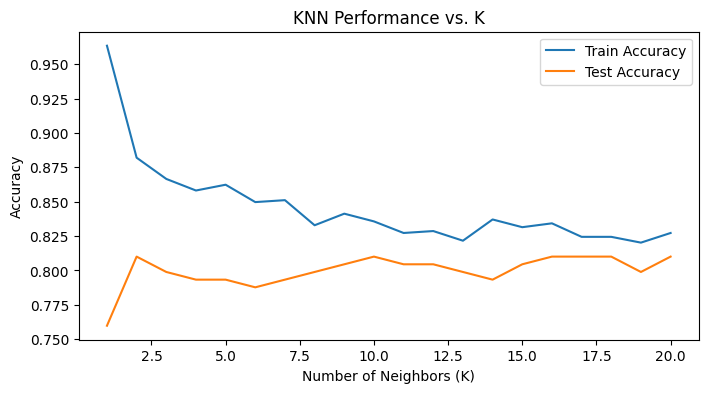

In [82]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Step 1. Normalize features (essential for KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Step 3. Train and evaluate a KNN model
# TODO: step 3 as described.
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 4 Experiment: tune K
k_values = range(1, 21)
train_acc, test_acc = [], []

for k in k_values:
    # TODO: step 4: create a model, fit it, and evaluate it, appending its
    # score to train_acc and test_acc
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(X_train, y_train)
    train_acc.append(model.score(X_train, y_train))
    test_acc.append(model.score(X_test, y_test))

plt.figure(figsize=(8,4))
plt.plot(k_values, train_acc, label="Train Accuracy")
plt.plot(k_values, test_acc, label="Test Accuracy")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Accuracy")
plt.title("KNN Performance vs. K")
plt.legend()
plt.show()

### 💬 Reflection

The KNN model achieved about 79% accuracy, which is solid but slightly lower than the random forest model. That makes sense: KNN is a simple, memory-based method; it relies entirely on proximity and can't easily capture more complex relationships in the data.

Precision and recall are balanced across both classes, showing the model makes reasonable predictions for survivors and non-survivors alike. However, KNN tends to struggle with noisy or overlapping data (like age and fare combinations that don't cleanly separate survivors from non-survivors).

Still, this performance demonstrates why KNN is a useful baseline model. It confirms that similarity-based reasoning can uncover real structure in the data, even without any training phase. And, it highlights how more sophisticated models, like Random Forests, build on that foundation to achieve stronger and more stable results.

**How does changing the value of K affect both training and testing accuracy? What does this tell you about the balance between overfitting (too small K) and underfitting (too large K) in your model?**

TODO: Answer here.

**Where on your plot do you see the “sweet spot” for K — the point of best generalization?
How would you justify that choice based on what you observe in the training and testing curves?**

TODO: Answer here.

**How does your best KNN model compare to your Decision Tree and Random Forest results?
What does that comparison suggest about when simple, instance-based models like KNN are effective versus when more structured models perform better?**

TODO: Answer here.